In [1]:
using LaTeXStrings
using Plots
using DelimitedFiles
using CSV
using DataFrames

# Error Mitigation using Clifford Data Regression on the IBM Utility Experiment

We now want to compare how the error mitigation methods shown in the introductory notebook compare for a larger scale system - namely the 127 qubit kicked Ising model on the heavy-hex lattice. These results come from the utility experiment by IBM (https://www.nature.com/articles/s41586-023-06096-3).

The computations were run on the cluster, but should also be executable on a laptop (to be verified). In this notebook, we just visualize the final results.

The unmitigated and mitigated results from IBM are available here: https://figshare.com/articles/dataset/Evidence-for-the-utility-of-quantum-computing-before-fault-tolerance/22500355?file=40506419 .


### Data for Comparison

In [2]:
## Mitigated values
IBM_mitigated_vals = [1.01688859, 1.00387483, 0.95615886, 0.95966435, 0.83946763,
    0.81185907, 0.54640995, 0.45518584, 0.19469377, 0.01301832,0.01016334] 
IBM_angles = [0.    , 0.1   , 0.2   , 0.3   , 0.4   , 0.5   , 0.6   , 0.7   , 0.8   , 1.    , 1.5707]

## Unmitigated values
IBM_unmitigated_vals = [ 0.4188991191900761,
0.004107759335343423,
0.11944580478416555,
0.49038646460776864,
0.4552471452020139,
0.055064655494323766,
0.3061535376123831,
0.4889782663914668,
0.3622122171682965,
-0.001980699802309258,
0.20175539633925924]
mixed_angles = [0.3, 1.0, 0.7, 0.0, 0.2, 0.8, 0.5, 0.1, 0.4, 1.5707, 0.6] 

## Flatiron tensor network values  
tn_vals = [9.99999254e-01,  9.99593653e-01,  9.95720077e-01,  9.88301532e-01,
        9.78553511e-01,  9.58023054e-01,  9.21986059e-01,  8.81726079e-01,
        8.49816779e-01,  8.24900527e-01,  7.91257641e-01,  7.37435202e-01,
        6.68573798e-01,  5.88096040e-01,  4.81874079e-01,  3.50316579e-01,
        2.26709331e-01,  1.39724659e-01,  7.86639143e-02,  4.24124371e-02,
        1.90595136e-02,  6.18879050e-03, -8.27168956e-04, -4.63372099e-03,
       -7.05202121e-03, -7.68387421e-03, -6.33121142e-03, -4.32594440e-03,
        6.52050191e-04,  1.72598340e-04,  5.64696020e-05, -7.70582375e-07]
tn_angles = LinRange(0, π/2, length(tn_vals));


### Results of our Error Mitigation using CDR (CPA), ZNE and vnCDR

In [3]:
## CPA runs using the full_run function in cpa.jl and angle_definition = pi/20
corr_energy_strict_CPA_mw_8_abs_coeff_4 = [0.7065161069772835, 0.013895199657957873, 0.3035052000959395, 1.0, 0.7297057122670905, 0.10201787586056714, 0.5625003211705719, 0.9964411572367162, 0.6821403023215343, 0.0, 0.35455599923322173]

corr_energy_strict_CPA_mw_10_abs_coeff_5 = [0.6559830795209787, 0.03757020163515776, 0.19871428844432265, 1.0, 0.7633298810612551, 0.08399958457748205, 0.5364756304558803, 0.9964229052022745, 0.5811603963242845, 0.0, 0.3619722848587214]

corr_energy_loose_small_mw_20_abs_coeff_5 = [0.9862160830390639, 0.9669770894085417, 0.9762834018844588, 1.0, 0.988234604903283, 0.9729353433717342, 0.9854083989538537, 0.9964229075384101, 0.9834148070672105, 0.0, 0.9731305461407511]

corr_energy_strict_small_mw_20_abs_coeff_5 = [0.9865422476520838, 0.9576113603343447, 0.9724810024695617, 0.9898424993388746, 0.9892628495178973, 0.9621033115360978, 0.9784855412596822, 0.990437911007951, 0.987422244782197, 0.9640772278026617, 0.9798932897544947];

In [4]:
# all method runs using the full_run_all_methods function in cpa.jl
# we have angle_def = pi/20, 3 noise levels = [1,1.5,2.0], training_circuit_generation_strict_perturbation.

df = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.157_20250505_121054.log", DataFrame, header = true)

rename!(df,Symbol.(["idx",
              "Exact_targets",
              "Noisy_targets",
              "ZNE_outputs",
              "CDR_outputs",
              "vnCDR_outputs"])
)


Row,idx,Exact_targets,Noisy_targets,ZNE_outputs,CDR_outputs,vnCDR_outputs
,Int64,Float64,Float64,Float64,Float64,Float64
1,1,NaN,0.418899,0.63934,0.985171,0.991986
2,2,NaN,0.00410776,0.00321809,0.962659,0.00677647
3,3,NaN,0.119446,0.236957,0.972574,0.377377
4,4,NaN,0.490386,0.888572,0.990594,1.00002
5,5,NaN,0.455247,0.631308,0.991059,0.987034
6,6,NaN,0.0550647,0.109381,0.962554,0.191025
7,7,NaN,0.306154,0.474096,0.981012,0.702679
8,8,NaN,0.488978,0.776714,0.991152,0.996252
9,9,NaN,0.362212,0.619332,0.981907,0.908762


In [5]:
# all method runs using the full_run_all_methods function in cpa.jl
# we have angle_def = pi/8, 3 noise levels = [1,1.5,2.0], training_circuit_generation_loose_perturbation (small).
df_8 = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.393_20250507_134634.log", DataFrame, header = true)
rename!(df_8,Symbol.(["idx","hvalues",
              "Exact_targets_pi_8",
              "Noisy_targets_pi_8",
              "ZNE_outputs_pi_8",
              "CDR_outputs_pi_8",
              "vnCDR_outputs_pi_8"]))

Row,idx,hvalues,Exact_targets_pi_8,Noisy_targets_pi_8,ZNE_outputs_pi_8,CDR_outputs_pi_8,vnCDR_outputs_pi_8
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,3.0,NaN,0.418899,0.63934,0.988712,0.972797
2,2,10.0,NaN,0.00410776,0.00321809,0.963226,0.00678199
3,3,7.0,NaN,0.119446,0.236957,0.967502,0.379389
4,4,0.0,NaN,0.490386,0.888572,1.0,1.0
5,5,2.0,NaN,0.455247,0.631308,0.988583,0.991379
6,6,8.0,NaN,0.0550647,0.109381,0.97494,0.188002
7,7,5.0,NaN,0.306154,0.474096,0.985425,0.702507
8,8,1.0,NaN,0.488978,0.776714,0.996423,0.996423
9,9,4.0,NaN,0.362212,0.619332,0.981999,0.899456


In [6]:
df_6 = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.524_20250507_134440.log", DataFrame, header = true)
rename!(df_6,Symbol.(["idx","hvalues",
              "Exact_targets_pi_6",
              "Noisy_targets_pi_6",
              "ZNE_outputs_pi_6",
              "CDR_outputs_pi_6",
              "vnCDR_outputs_pi_6"]))

Row,idx,hvalues,Exact_targets_pi_6,Noisy_targets_pi_6,ZNE_outputs_pi_6,CDR_outputs_pi_6,vnCDR_outputs_pi_6
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,3.0,NaN,0.418899,0.63934,0.985683,0.986463
2,2,10.0,NaN,0.00410776,0.00321809,0.958024,0.00678785
3,3,7.0,NaN,0.119446,0.236957,0.968191,0.377916
4,4,0.0,NaN,0.490386,0.888572,1.0,1.0
5,5,2.0,NaN,0.455247,0.631308,0.988666,0.99064
6,6,8.0,NaN,0.0550647,0.109381,0.966431,0.189784
7,7,5.0,NaN,0.306154,0.474096,0.982717,0.702043
8,8,1.0,NaN,0.488978,0.776714,0.996423,0.996423
9,9,4.0,NaN,0.362212,0.619332,0.984344,0.910134


In [7]:
## angle_def = pi/6, strict small
df_6_strict_small = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.524_20250507_174340.log", DataFrame, header = true)
rename!(df_6_strict_small,Symbol.(["idx","hvalues",
              "Exact_targets",
              "Noisy_targets",
              "ZNE_outputs",
              "CDR_outputs",
              "vnCDR_outputs"]))

Row,idx,hvalues,Exact_targets,Noisy_targets,ZNE_outputs,CDR_outputs,vnCDR_outputs
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,3.0,NaN,0.418899,0.63934,0.985461,0.983457
2,2,10.0,NaN,0.00410776,0.00321809,0.976809,0.00678268
3,3,7.0,NaN,0.119446,0.236957,0.969181,0.381656
4,4,0.0,NaN,0.490386,0.888572,0.991037,0.999884
5,5,2.0,NaN,0.455247,0.631308,0.988775,0.984896
6,6,8.0,NaN,0.0550647,0.109381,0.976969,0.190025
7,7,5.0,NaN,0.306154,0.474096,0.981133,0.699118
8,8,1.0,NaN,0.488978,0.776714,0.993914,0.996265
9,9,4.0,NaN,0.362212,0.619332,0.983021,0.906467


In [8]:
df_6_strict_CPA = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.524_20250507_174942.log", DataFrame, header = true)
rename!(df_6_strict_CPA,Symbol.(["idx","hvalues",
              "Exact_targets",
              "Noisy_targets",
              "ZNE_outputs",
              "CDR_outputs",
              "vnCDR_outputs"]))

Row,idx,hvalues,Exact_targets,Noisy_targets,ZNE_outputs,CDR_outputs,vnCDR_outputs
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,3.0,NaN,0.418899,0.63934,0.786345,0.98908
2,2,10.0,NaN,0.00410776,0.00321809,0.010233,0.00678243
3,3,7.0,NaN,0.119446,0.236957,0.210953,0.37369
4,4,0.0,NaN,0.490386,0.888572,0.746975,1.0
5,5,2.0,NaN,0.455247,0.631308,0.702303,0.987207
6,6,8.0,NaN,0.0550647,0.109381,0.122221,0.189468
7,7,5.0,NaN,0.306154,0.474096,0.500751,0.696696
8,8,1.0,NaN,0.488978,0.776714,0.798819,0.996239
9,9,4.0,NaN,0.362212,0.619332,0.64778,0.902759


In [9]:
## pi/6 plot with 7 noise levels, linear fit 
df_6_strict_CPA_7_noise = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.524_20250508_193246.log", DataFrame, header = true)
rename!(df_6_strict_CPA_7_noise,Symbol.(["idx","hvalues",
              "Exact_targets",
              "Noisy_targets",
              "ZNE_outputs",
              "CDR_outputs",
              "vnCDR_outputs"]))
            

Row,idx,hvalues,Exact_targets,Noisy_targets,ZNE_outputs,CDR_outputs,vnCDR_outputs
,Int64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,3.0,NaN,0.418899,0.577108,0.67009,0.924086
2,2,10.0,NaN,0.00410776,0.00273485,0.0102718,0.00568867
3,3,7.0,NaN,0.119446,0.210673,0.221227,0.380867
4,4,0.0,NaN,0.490386,0.859077,0.853018,0.999879
5,5,2.0,NaN,0.455247,0.573422,0.779707,0.984445
6,6,8.0,NaN,0.0550647,0.0958797,0.106996,0.189914
7,7,5.0,NaN,0.306154,0.429396,0.51785,0.712842
8,8,1.0,NaN,0.488978,0.735534,0.876545,0.99632
9,9,4.0,NaN,0.362212,0.56289,0.64648,0.879069


In [14]:
## pi/20 all methods lin and expo, small loose
df_20_lin_exp = CSV.read("fig_4b_utility_1e-5_all/tfim_utility_nq=127_angle_def=0.157_20250511_185921.log", DataFrame, header = true)
rename!(df_20_lin_exp,Symbol.(["idx","hvalues",
              "Exact_targets",
              "Noisy_targets",
              "ZNE_outputs_exp",
              "ZNE_outputs_lin",
              "CDR_outputs",
              "vnCDR_outputs_exp",
              "vnCDR_outputs_lin"]))

Row,idx,hvalues,Exact_targets,Noisy_targets,ZNE_outputs_exp,ZNE_outputs_lin,CDR_outputs,vnCDR_outputs_exp,vnCDR_outputs_lin
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,3.0,NaN,0.418899,0.982369,0.577108,0.989647,1.01388,0.995776
2,2,10.0,NaN,0.00410776,0.00689258,0.00273485,0.958983,5.7277,0.00656844
3,3,7.0,NaN,0.119446,0.390003,0.210673,0.964937,1.55641,0.395381
4,4,0.0,NaN,0.490386,1.00099,0.859077,1.0,1.0,1.0
5,5,2.0,NaN,0.455247,0.953975,0.573422,0.9893,0.956323,0.971623
6,6,8.0,NaN,0.0550647,0.194132,0.0958797,0.964457,1.90597,0.232289
7,7,5.0,NaN,0.306154,0.713147,0.429396,0.97915,1.1827,0.726665
8,8,1.0,NaN,0.488978,0.95858,0.735534,0.996423,0.996423,0.996423
9,9,4.0,NaN,0.362212,0.916,0.56289,0.981605,1.02474,0.921865


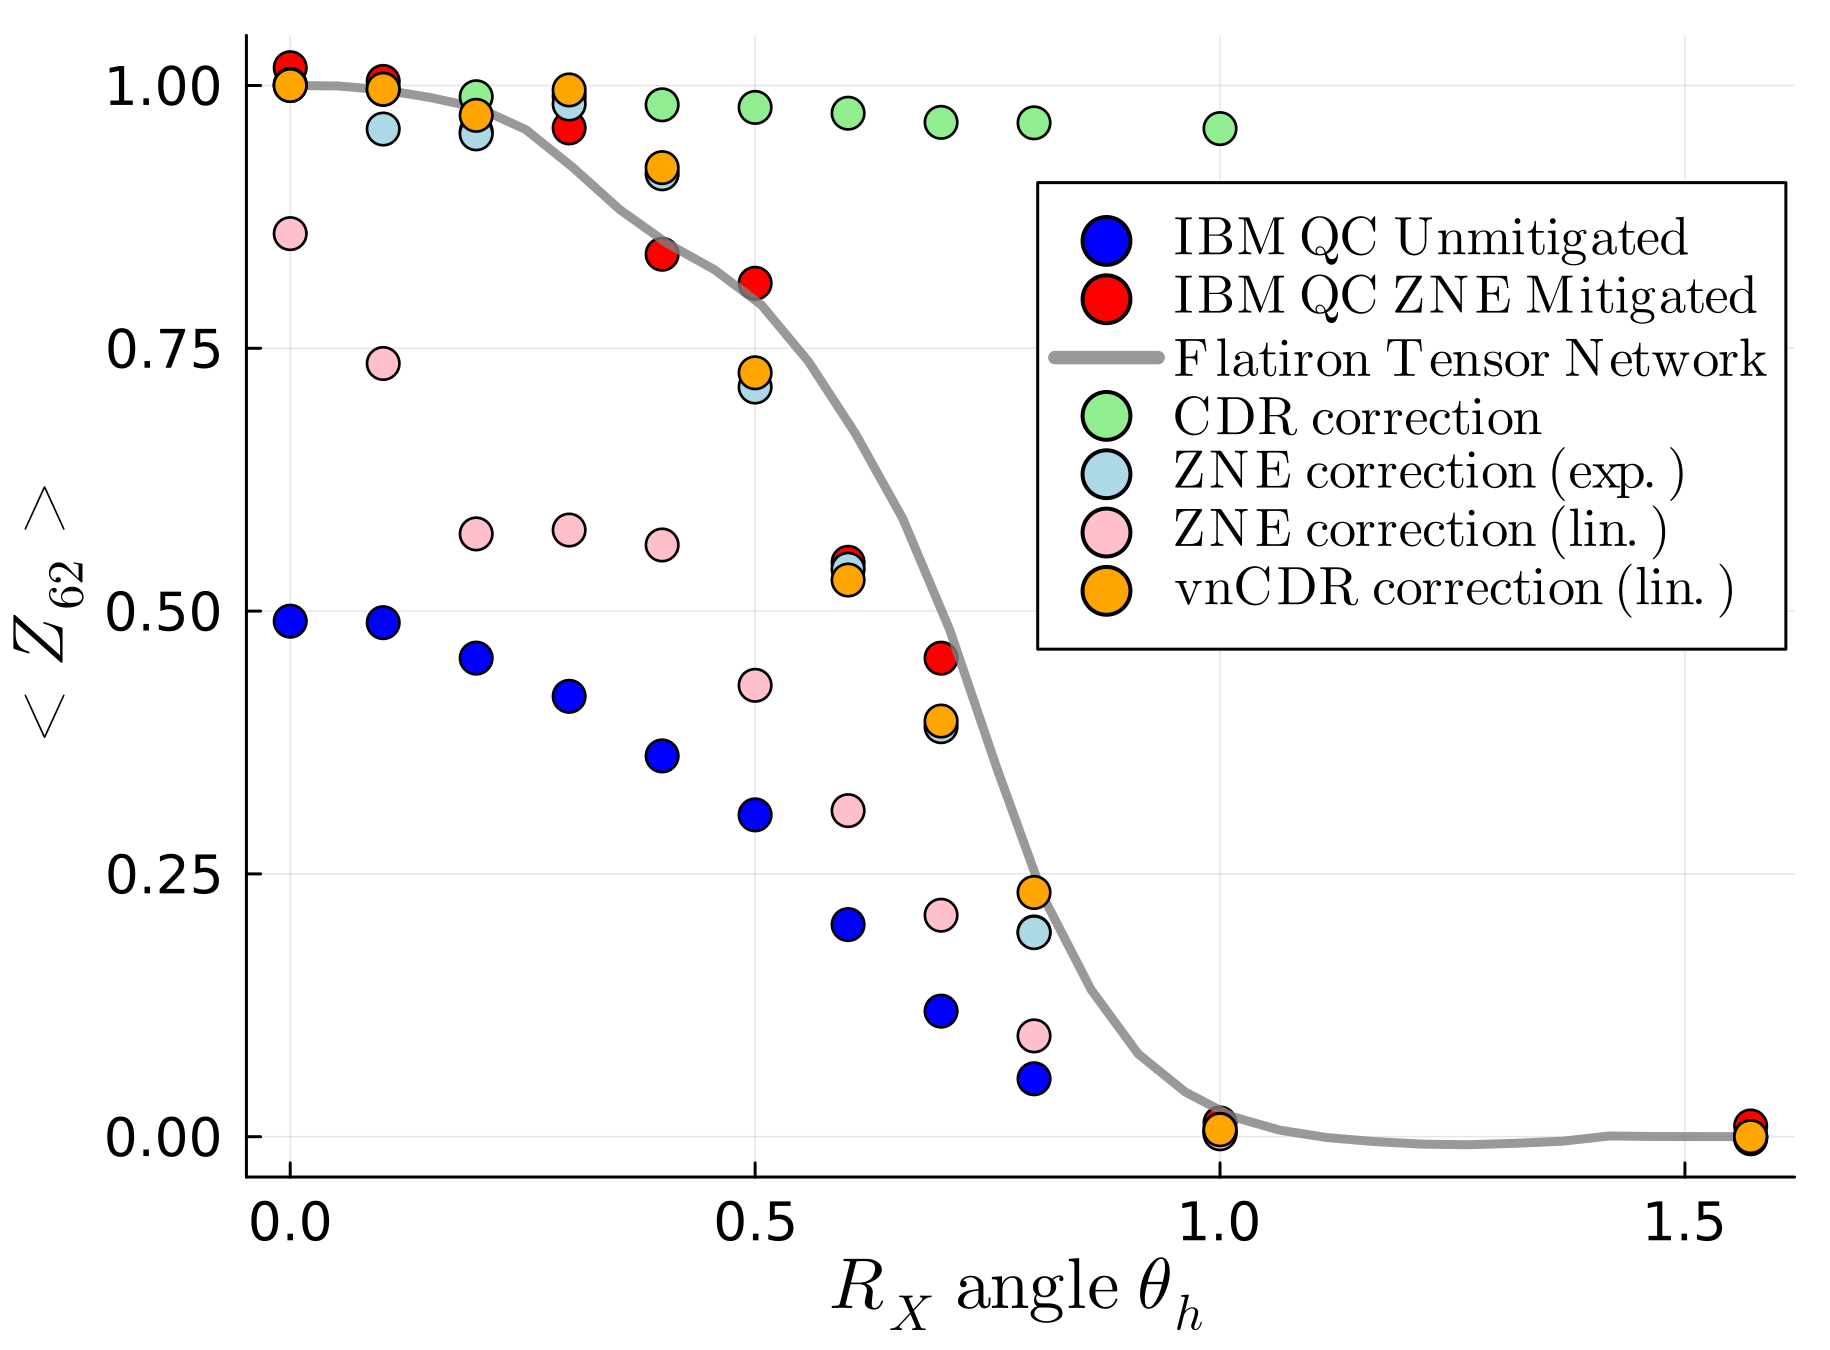

In [29]:
## pi/20 plot, loose small
# data for comparison
scatter(mixed_angles, IBM_unmitigated_vals, label=L"\textrm{IBM\ QC\ Unmitigated}", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", legend=(0.60,0.82),size = (610,450), dpi = 300,
guidefontsize=16,
tickfontsize=12,
legendfontsize=12, ms = 6)
scatter!(IBM_angles, IBM_mitigated_vals, label=L"\textrm{IBM\ QC\ ZNE\ Mitigated}", color="Red", ms = 6)
plot!(tn_angles, tn_vals, label=L"\textrm{Flatiron\ Tensor\ Network}", color="grey", alpha = 0.8, linewidth=3,ms = 6)


## max_weight = 20, min_abs_coeff = 1e-5

## CPA / CDR
#scatter!(mixed_angles, corr_energy_loose_small_mw_20_abs_coeff_5, label=L"\textrm{CPA\ correction}", color="lightgreen",  linewidth=3,ms = 6)
scatter!(mixed_angles, df_20_lin_exp.CDR_outputs, label=L"\textrm{CDR\ correction}", color="lightgreen", linewidth=3,ms = 6)
## ZNE
#scatter!(mixed_angles, df.ZNE_outputs, label = L"\textrm{ZNE\ correction (3\ vals, lin.) }", color = "lightblue",ms = 6)
#scatter!(mixed_angles, df_6_strict_CPA_7_noise.ZNE_outputs, label = L"\textrm{ZNE\ correction (7\ vals, lin.)}", color = "black",ms = 6)
scatter!(mixed_angles, df_20_lin_exp.ZNE_outputs_exp, label = L"\textrm{ZNE\ correction\ (exp.)}", color = "lightblue",ms = 6)
scatter!(mixed_angles, df_20_lin_exp.ZNE_outputs_lin, label = L"\textrm{ZNE\ correction\ (lin.)}", color = "pink",ms = 6)
## vnCDR
#scatter!( mixed_angles, df.vnCDR_outputs,label = L"\textrm{vnCDR\ correction}", color = "orange",ms = 6)
#scatter!(mixed_angles, df_6_strict_CPA_7_noise.vnCDR_outputs, label = L"\textrm{vnCDR\ correction (7\ vals)}", color = "pink",ms = 6)
#scatter!(mixed_angles, df_20_lin_exp.vnCDR_outputs_exp, label = L"\textrm{vnCDR\ correction (7\ vals, exp.)}", color = "orange",ms = 6)
scatter!(mixed_angles, df_20_lin_exp.vnCDR_outputs_lin, label = L"\textrm{vnCDR\ correction\ (lin.)}", color = "orange",ms = 6)
## CDR
#png("utility_corr_pi_20")

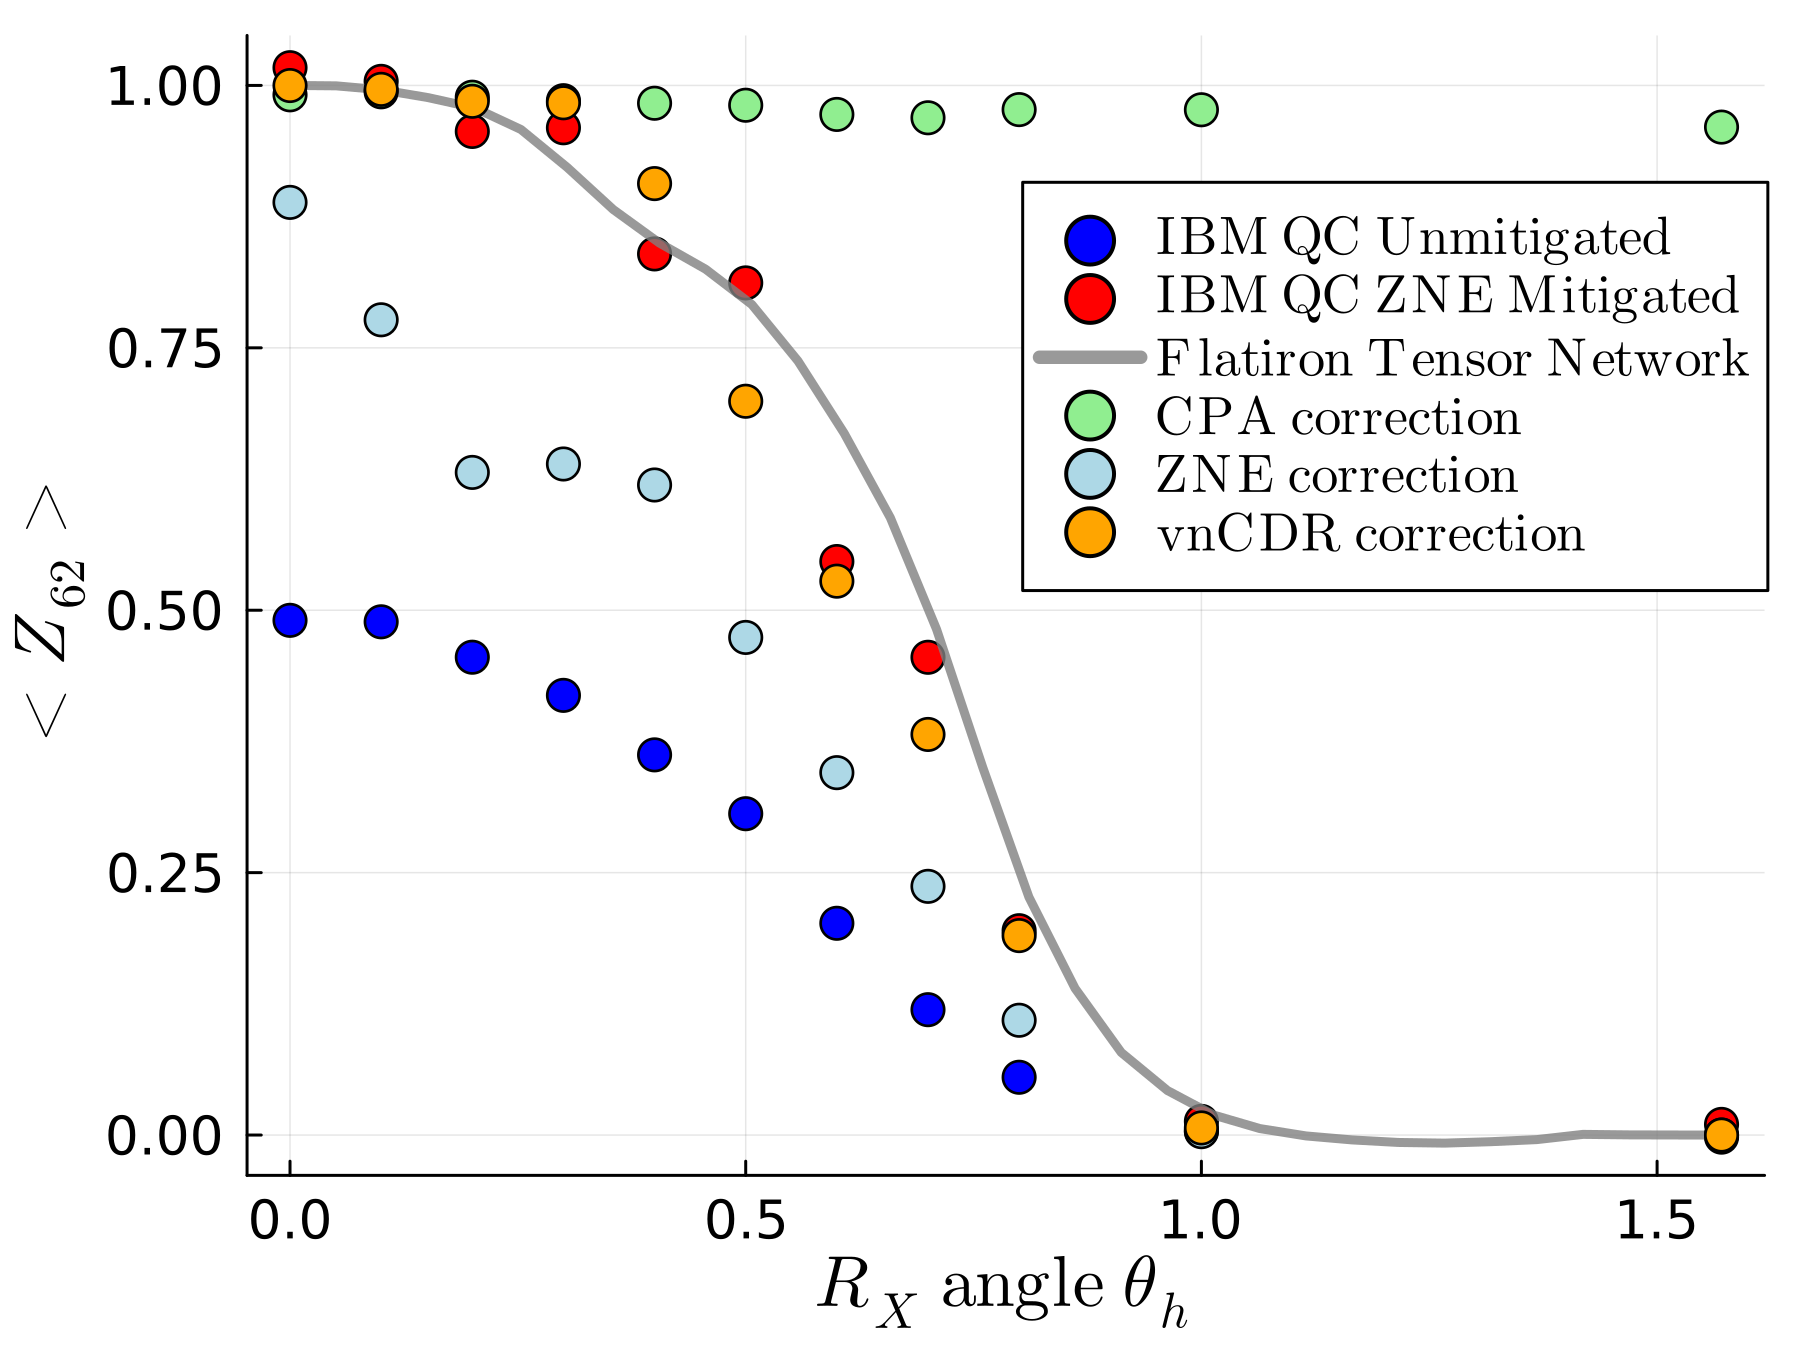

In [12]:
# pi/6 plot, strict small
# data for comparison
scatter(mixed_angles, IBM_unmitigated_vals, label=L"\textrm{IBM\ QC\ Unmitigated}", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", legend=(0.60,0.82),size = (600,450), dpi = 300,
guidefontsize=16,
tickfontsize=12,
legendfontsize=12, ms = 6)
scatter!(IBM_angles, IBM_mitigated_vals, label=L"\textrm{IBM\ QC\ ZNE\ Mitigated}", color="Red", ms = 6)
plot!(tn_angles, tn_vals, label=L"\textrm{Flatiron\ Tensor\ Network}", color="grey", alpha = 0.8, linewidth=3,ms = 6)

## max_weight = 20, min_abs_coeff = 1e-5

## CPA / CDR
scatter!(mixed_angles,df_6_strict_small.CDR_outputs, label=L"\textrm{CPA\ correction}", color="lightgreen", linewidth=3, ms = 6)

## ZNE
scatter!(mixed_angles,df_6_strict_small.ZNE_outputs, label =L"\textrm{ZNE\ correction}", color = "lightblue", ms = 6)

## vnCDR
scatter!(mixed_angles,df_6_strict_small.vnCDR_outputs, label = L"\textrm{vnCDR\ correction}", color = "orange", ms = 6)

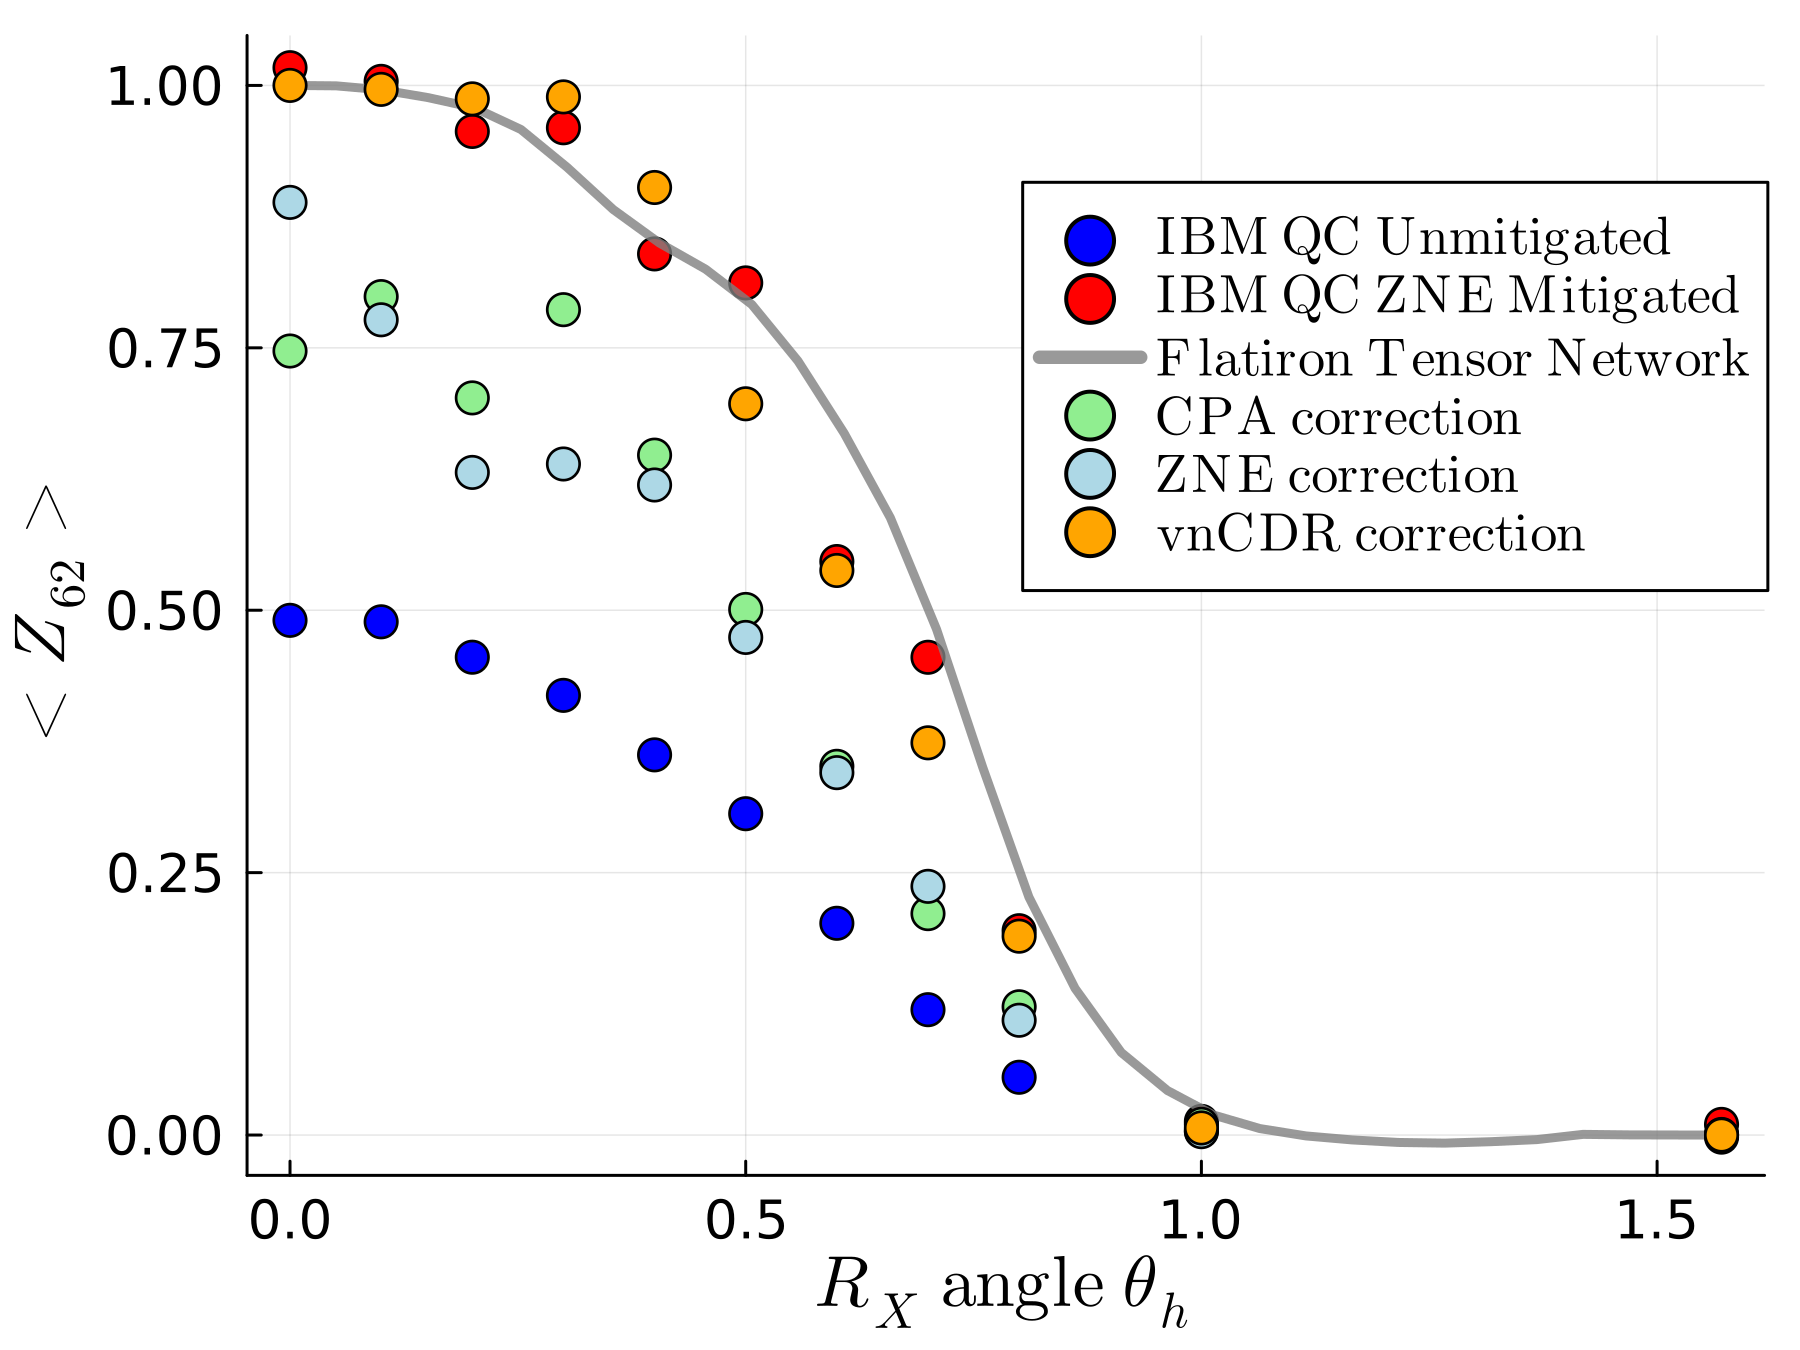

In [13]:
# pi/6 plot, strict CPA
# data for comparison
scatter(mixed_angles, IBM_unmitigated_vals, label=L"\textrm{IBM\ QC\ Unmitigated}", color=:blue, lw=2, xlabel=L" R_X\  \textrm{angle}\ \theta_h", ylabel=L"<Z_{62}>", legend=(0.60,0.82),size = (600,450), dpi = 300,
guidefontsize=16,
tickfontsize=12,
legendfontsize=12, ms = 6)
scatter!(IBM_angles, IBM_mitigated_vals, label=L"\textrm{IBM\ QC\ ZNE\ Mitigated}", color="Red", ms = 6)
plot!(tn_angles, tn_vals, label=L"\textrm{Flatiron\ Tensor\ Network}", color="grey", alpha = 0.8, linewidth=3,ms = 6)


## max_weight = 20, min_abs_coeff = 1e-5

## CPA / CDR
scatter!(mixed_angles, df_6_strict_CPA.CDR_outputs, label=L"\textrm{CPA\ correction}", color="lightgreen", linewidth=3, ms = 6)

## ZNE
scatter!(mixed_angles,df_6_strict_CPA.ZNE_outputs, label =L"\textrm{ZNE\ correction}", color = "lightblue", ms= 6)

## vnCDR
scatter!(mixed_angles,df_6_strict_CPA.vnCDR_outputs, label = L"\textrm{vnCDR\ correction}", color = "orange", ms = 6)